In [1]:
# !pip install imutils
# !pip install nibabel

In [2]:
import os
import nibabel as nib
import preprocessing as pre

In [3]:
import importlib
importlib.reload(pre)

<module 'preprocessing' from '/home/alice/GIT/Variational-Auto-Encoders-for-cardiac-shape-modeling/preprocessing.py'>

In [4]:
dataset_path = './ACDC/database'
testing_folder = os.path.join(dataset_path, 'testing')
training_folder = os.path.join(dataset_path, 'training')

nb_training = len(os.listdir(training_folder))
nb_testing = len(os.listdir(testing_folder))

# Extracting training images paths
images_train_ED_path, masks_train_ED_path, images_train_ES_path, masks_train_ES_path = pre.preprocess_files_acdc(training_folder, nb_training)

# Extracting testing images paths
images_test_ED_path, masks_test_ED_path, images_test_ES_path, masks_test_ES_path = pre.preprocess_files_acdc(testing_folder, nb_testing, test=True)

In [5]:
print('----------- Training dataset -----------')
print('Number of images ED:\t{}'.format(len(images_train_ED_path)))
print('Number of masks ED:\t{}'.format(len(masks_train_ED_path)))
print('Number of images ES:\t{}'.format(len(images_train_ES_path)))
print('Number of masks ES:\t{}'.format(len(masks_train_ES_path)))

print('\n----------- Testing dataset -----------')
print('Number of images ED:\t{}'.format(len(images_test_ED_path)))
print('Number of masks ED:\t{}'.format(len(masks_test_ED_path)))
print('Number of images ES:\t{}'.format(len(images_test_ES_path)))
print('Number of masks ES:\t{}'.format(len(masks_test_ES_path)))

----------- Training dataset -----------
Number of images ED:	100
Number of masks ED:	100
Number of images ES:	100
Number of masks ES:	100

----------- Testing dataset -----------
Number of images ED:	50
Number of masks ED:	50
Number of images ES:	50
Number of masks ES:	50


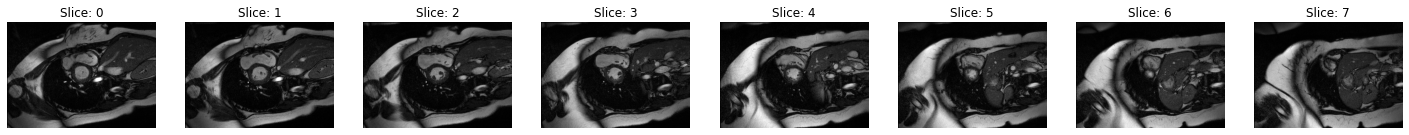

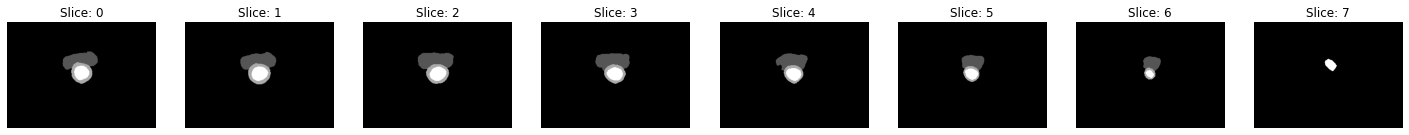

In [6]:
# Show images and masks of training dataset
patient = 99

image = pre.nii_reader(images_train_ED_path[patient])
mask = pre.nii_reader(masks_train_ED_path[patient])

pre.visualize_image_mask(image, mask, image.shape[2])

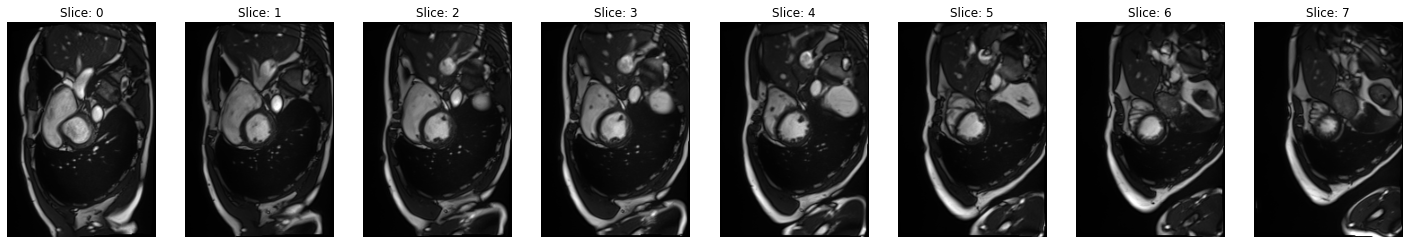

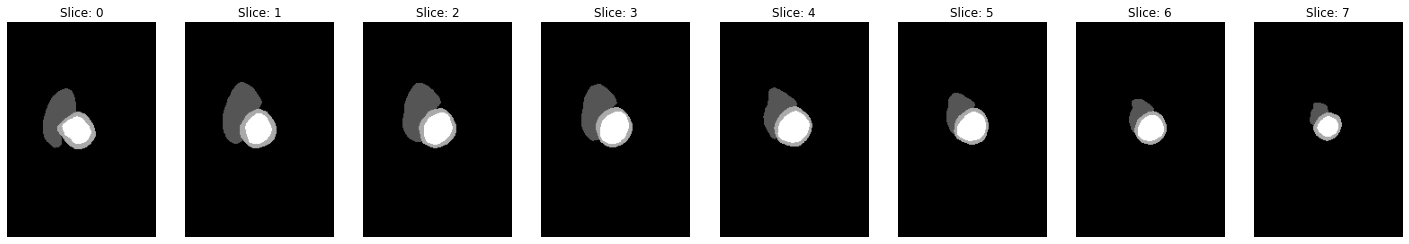

In [7]:
# Show images and masks of testing dataset
patient = 20

image = pre.nii_reader(images_test_ED_path[patient])
mask = pre.nii_reader(masks_test_ED_path[patient])

pre.visualize_image_mask(image, mask, image.shape[2])

In [8]:
# Loading the masks
masks_train_ED = pre.heart_mask_loader(masks_train_ED_path)
masks_train_ES = pre.heart_mask_loader(masks_train_ES_path)
masks_test_ED = pre.heart_mask_loader(masks_test_ED_path)
masks_test_ES = pre.heart_mask_loader(masks_test_ES_path)

In [9]:
# Rotate masks so that the relative position of the LV and RV is always the same
r_masks_train_ED = pre.align_heart_mask(masks_train_ED)
r_masks_train_ES = pre.align_heart_mask(masks_train_ES)
r_masks_test_ED = pre.align_heart_mask(masks_test_ED)
r_masks_test_ES = pre.align_heart_mask(masks_test_ES)

In [10]:
# Freeing memory
del masks_train_ED, masks_train_ES, masks_test_ED, masks_test_ES

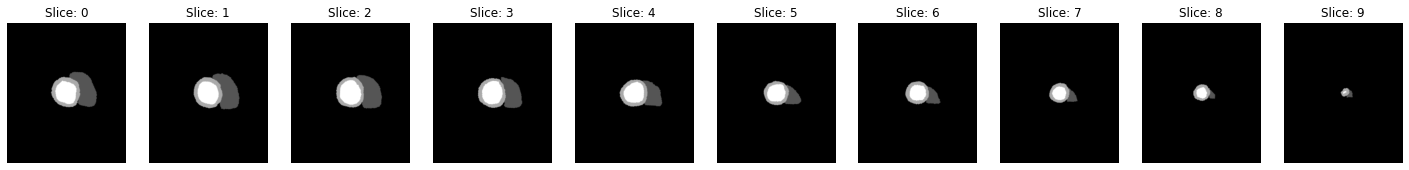

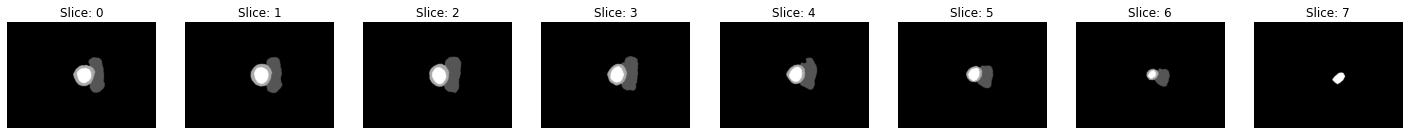

In [11]:
# Show aligned masks
patient = 61
pre.visualize_mask(r_masks_train_ED[patient])

patient = 99
pre.visualize_mask(r_masks_train_ED[patient])

In [12]:
# Crops masks
c_masks_train_ED = pre.crop_heart_mask(r_masks_train_ED)
c_masks_train_ES = pre.crop_heart_mask(r_masks_train_ES)
c_masks_test_ED = pre.crop_heart_mask(r_masks_test_ED)
c_masks_test_ES = pre.crop_heart_mask(r_masks_test_ES)

In [13]:
# Freeing memory
del r_masks_train_ED, r_masks_train_ES, r_masks_test_ED, r_masks_test_ES

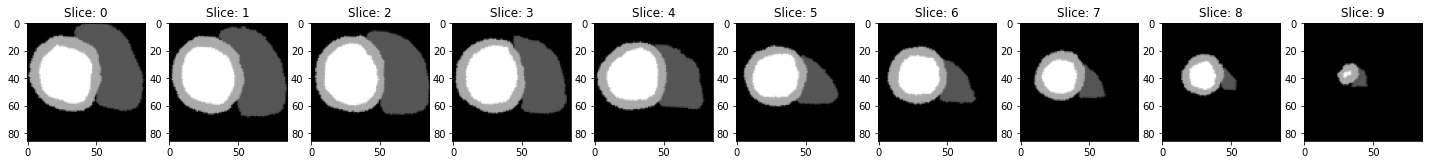

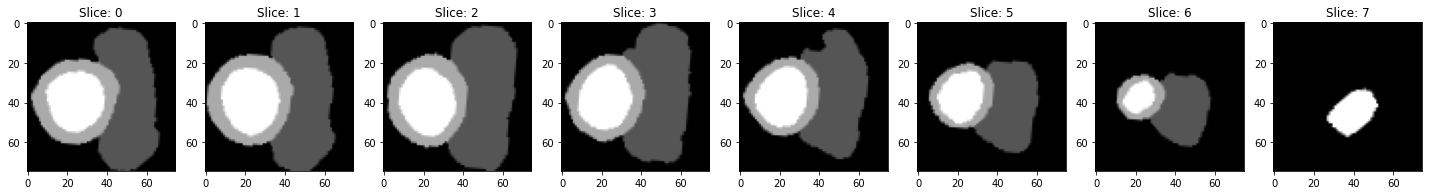

In [14]:
# Show aligned and cropped masks
patient = 61
pre.visualize_mask(c_masks_train_ED[patient], show_axis=True)

patient = 99
pre.visualize_mask(c_masks_train_ED[patient], show_axis=True)

In [15]:
# Standardize image size (inputs of the network must be of same size)
p_masks_train_ED = pre.resize_heart_mask(c_masks_train_ED)
p_masks_train_ES = pre.resize_heart_mask(c_masks_train_ES)
p_masks_test_ED = pre.resize_heart_mask(c_masks_test_ED)
p_masks_test_ES = pre.resize_heart_mask(c_masks_test_ES)

In [16]:
# Freeing memory
del c_masks_train_ED, c_masks_train_ES, c_masks_test_ED, c_masks_test_ES

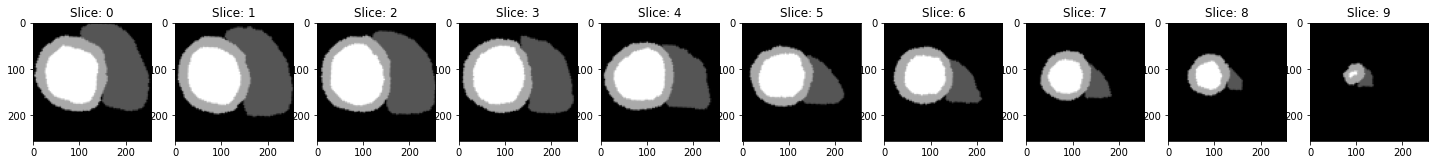

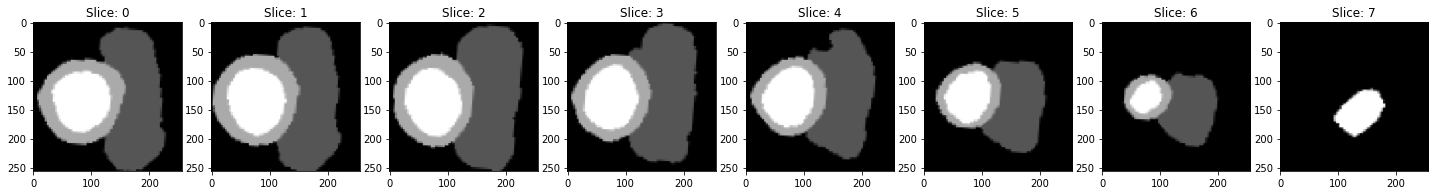

In [17]:
# Show aligned and cropped masks
patient = 61
pre.visualize_mask(p_masks_train_ED[patient], show_axis=True)

patient = 99
pre.visualize_mask(p_masks_train_ED[patient], show_axis=True)

In [18]:
# Separate the frames, each frame will treated as a 2D image
masks_train_ED_2d = pre.convert_3D_to_2D(p_masks_train_ED)
masks_train_ES_2d = pre.convert_3D_to_2D(p_masks_train_ES)
masks_test_ED_2d = pre.convert_3D_to_2D(p_masks_test_ED)
masks_test_ES_2d = pre.convert_3D_to_2D(p_masks_test_ES)

In [19]:
# Freeing memory
del p_masks_train_ED, p_masks_train_ES, p_masks_test_ED, p_masks_test_ES

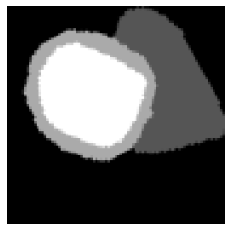

In [20]:
# Show 2D mask
idx = 1
pre.visualize_2d_mask(masks_train_ED_2d[idx])

In [21]:
# Translate multilabel mask into multi channel mask (each channel represents a different structure)
masks_train_ED_channels = pre.heart_mask_extraction(masks_train_ED_2d)
masks_train_ES_channels = pre.heart_mask_extraction(masks_train_ES_2d)
masks_test_ED_channels = pre.heart_mask_extraction(masks_test_ED_2d)
masks_test_ES_channels = pre.heart_mask_extraction(masks_test_ES_2d)

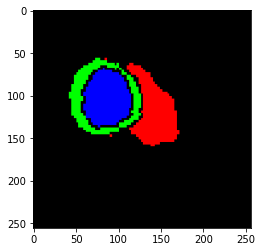

In [22]:
# Show multi-channel mask
idx = 99
pre.visualize_multichannel_mask(masks_train_ED_channels[idx][:,:,1:])